# Homework 4

# Задача №1 - Хвост кита

Не так давно на kaggle было соревнование по классификации горбатых китов по снимках их хвостов. Одним из приемов для улучшения работы нейронной сети было выделение маски хвоста. Затем по этой маске вырезался хвост на исходном изображении, нормировался, отображался на черный фон и подавался нейронной сети на вход. 

Ваша задача - написать программу, которая совершит предобработку картинки, описанную выше. Т.е. найти маску хвоста, по маске вырезать из исходного изображения хвост, нормировать изображение хвоста так, чтобы оно всегда имело один заданный размер и равномерно занимало место, то есть, если хвост был повернут, его нужно выпрямить.

Изображения хвостов находятся в папке whale_tail/images к этому занятию. Разметка картинок (маски хвостов) лежат в папке whale_tail/ground_truth. После выделения хвоста посчитайте IoU для каждой картинки (ипсользуя маски из whale_tail/ground_truth)

<table><tr>
    <td> <img src="whale_tail/images/test_image_01.jpg" alt="Drawing" style="width: 400px;"/> 
    <td> <img src="whale_tail/ground_truth/test_image_01.png" alt="Drawing" style="width: 400px;"/> </td>
  
</tr></table>

# IoU 
 Intercetion over union - число от 0 до 1, показывающее, насколько у двух объектов (эталонного (ground true) и текущего) совпадает внутренний “объем”.
 

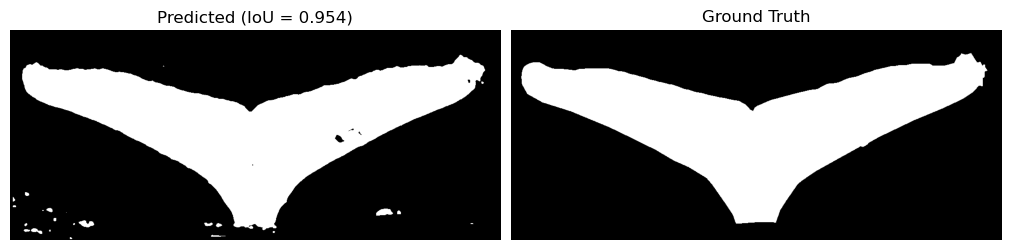

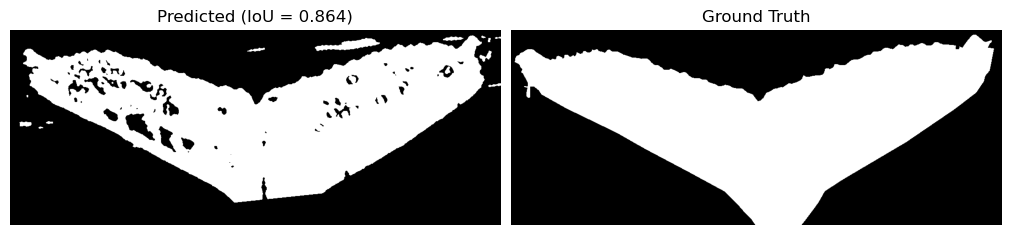

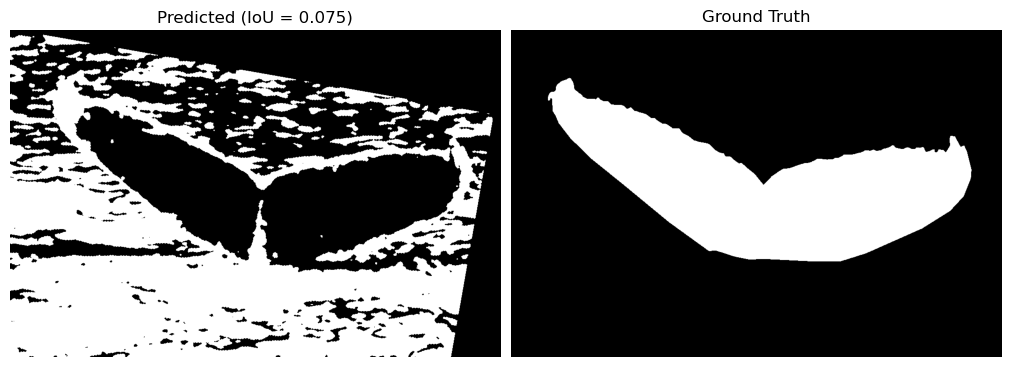

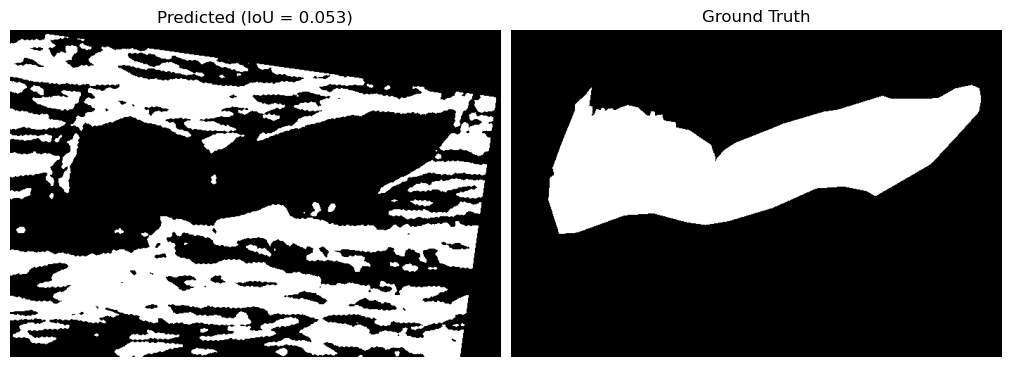

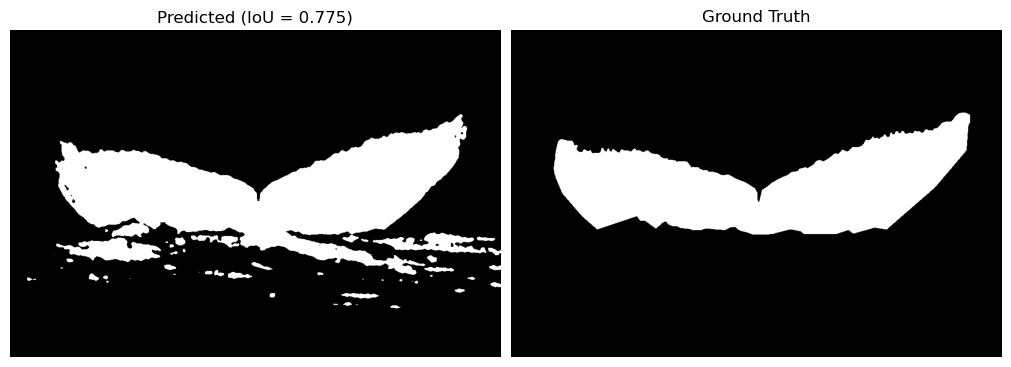

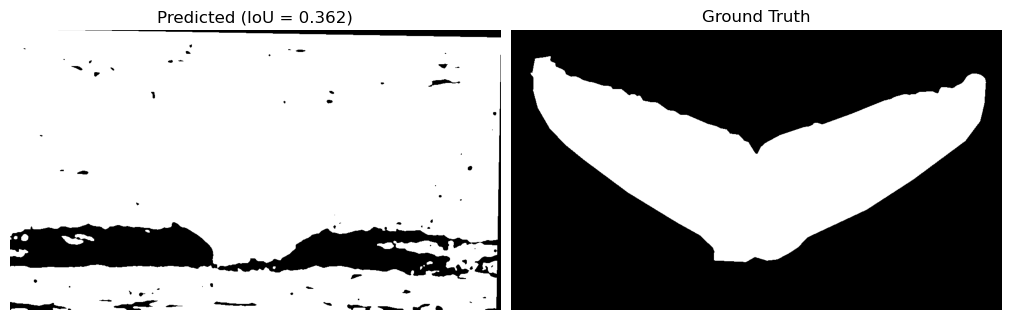

In [1]:
import cv2
import glob
import numpy as np
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

def generate_shape_mask(dimensions):
    """
    Генерация базовой формы маски и инверсированной маски.
    """
    height, width = dimensions[:2]
    shape_mask = np.zeros((int(0.8 * height), int(0.8 * width)), dtype=np.uint8)
    
    # Определяем параметры эллипсов
    ellipse1_center = (width // 4, height // 3)
    ellipse2_center = (int(width * 2.2 / 4), height // 3)
    ellipse_axes = (width // 4, height // 6)

    # Создаем базовую форму
    shape_mask = cv2.ellipse(shape_mask, ellipse1_center, axes=ellipse_axes, angle=20,
                              startAngle=0, endAngle=360, color=255, thickness=-1)
    shape_mask = cv2.ellipse(shape_mask, ellipse2_center, axes=ellipse_axes, angle=160,
                              startAngle=0, endAngle=360, color=255, thickness=-1)
    shape_mask = cv2.ellipse(shape_mask, (width // 5, height * 3 // 5), axes=ellipse_axes, angle=20,
                              startAngle=0, endAngle=360, color=0, thickness=-1)
    shape_mask = cv2.ellipse(shape_mask, (int(width * 3 / 5), height * 3 // 5), axes=ellipse_axes, angle=160,
                              startAngle=0, endAngle=360, color=0, thickness=-1)

    # Создаем инверсированную маску
    inverse_mask = np.zeros_like(shape_mask)
    inverse_mask[shape_mask == 0] = 255

    return shape_mask[:int(0.8 * 0.8 * height)], inverse_mask[:int(0.8 * 0.8 * height)]

def apply_rotation(image, pivot, rotation_angle):
    """
    Применение поворота к изображению вокруг заданного центра.
    """
    rotation_matrix = cv2.getRotationMatrix2D(center=pivot, angle=rotation_angle, scale=1)
    return cv2.warpAffine(image, rotation_matrix, image.shape[::-1])

def calculate_iou(predicted_mask, ground_truth):
    """
    Вычисление метрики IoU (Intersection over Union).
    """
    intersection = predicted_mask * ground_truth
    union = (predicted_mask + ground_truth) > 0
    return intersection.sum() / union.sum()

def detect_mask(input_gray_image):
    """
    Детектирование маски из серого изображения.
    """
    # Сглаживание изображения
    smoothed_image = cv2.GaussianBlur(input_gray_image, (15, 15), 0)

    # Вычисляем порог методом Отсу
    masked_smooth = np.ma.masked_array(smoothed_image, smoothed_image == 0)
    threshold_value = threshold_otsu(masked_smooth.compressed())
    binary_mask = ((smoothed_image < threshold_value) & (smoothed_image > 0)).astype(np.uint8)

    # Генерация базовой и инверсированной масок
    adjusted_dimensions = (input_gray_image.shape[1] // 2, input_gray_image.shape[1])
    main_mask, inverted_mask = generate_shape_mask(adjusted_dimensions)

    # Инициализация параметров для поиска оптимальной маски
    lowest_score = 1
    optimal_mask = None

    # Сравнение с базовой маской
    for angle in np.arange(-20, 21, 1):
        rotated_mask = apply_rotation(binary_mask * 255, (0, 0), rotation_angle=angle)
        comparison_map = cv2.matchTemplate(rotated_mask, main_mask, cv2.TM_SQDIFF_NORMED)
        min_difference, _, min_location, _ = cv2.minMaxLoc(comparison_map)
        
        if min_difference < lowest_score:
            lowest_score = min_difference
            optimal_mask = apply_rotation(rotated_mask, (0, 0), rotation_angle=-angle) > 50

    # Сравнение с инверсированной маской
    for angle in np.arange(-20, 21, 1):
        rotated_mask = apply_rotation(binary_mask * 255, (0, 0), rotation_angle=angle)
        comparison_map = cv2.matchTemplate(rotated_mask, inverted_mask, cv2.TM_SQDIFF_NORMED)
        min_difference, _, min_location, _ = cv2.minMaxLoc(comparison_map)

        if min_difference < lowest_score:
            lowest_score = min_difference
            optimal_mask = apply_rotation(rotated_mask, (0, 0), rotation_angle=-angle) > 50

    return optimal_mask

def process_images(image_paths, ground_truth_paths):
    """
    Обработка изображений и вычисление метрики IoU для каждого изображения.
    """
    image_count = len(image_paths)
    plot_index = 1

    for idx in range(image_count):
        # Загружаем изображения
        input_image = cv2.imread(image_paths[idx])
        grayscale_image = cv2.cvtColor(input_image.copy(), cv2.COLOR_BGR2GRAY)
        ground_truth = cv2.imread(ground_truth_paths[idx])
        actual_mask = cv2.cvtColor(ground_truth, cv2.COLOR_BGR2GRAY) > 0

        # Генерируем предсказанную маску
        predicted_mask = detect_mask(grayscale_image)

        # Вычисляем IoU
        iou_score = calculate_iou(predicted_mask, actual_mask)

        # Визуализация результатов
        plt.figure(figsize=(10, 100), constrained_layout=True)

        plt.subplot(image_count, 2, plot_index)
        plt.title(f"Predicted (IoU = {iou_score:.3f})")
        plt.axis('off')
        plt.imshow(predicted_mask, cmap='gray')
        plot_index += 1

        plt.subplot(image_count, 2, plot_index)
        plt.title("Ground Truth")
        plt.axis('off')
        plt.imshow(actual_mask, cmap='gray')
        plot_index += 1

if __name__ == "__main__":
    # Пути к изображениям и истинным маскам
    image_paths = sorted(glob.glob('./whale_tail/images/*.jpg'))
    ground_truth_paths = sorted(glob.glob('./whale_tail/ground_truth/*.png'))

    # Обработка изображений
    process_images(image_paths, ground_truth_paths)


# Задача №2 - Найти шаблон на изображении с помощью HOG и кросс-корреляции

Ваша задача - написать программу, которая сможет найти шаблон одного глаза на нескольких изображениях, в том числе затемненных. Использовать нужно HOG представление изображений, поиск шаблона сделать с помощью кросс-корреляции 

Изображение глаз человека и шаблон, который нужно на нем найти, находятся в папке hog

<table><tr>
    <td> <img src="hog/eye.png" alt="Drawing" style="width: 400px;"/> 
</tr></table>     

<table><tr>
    <td> <img src="hog/eyes.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/eyes_dark.jpg" alt="Drawing" style="width: 400px;"/> </td>
      <td> <img src="hog/woman.jpg" alt="Drawing" style="width: 200px;"/> </td>

</tr></table>

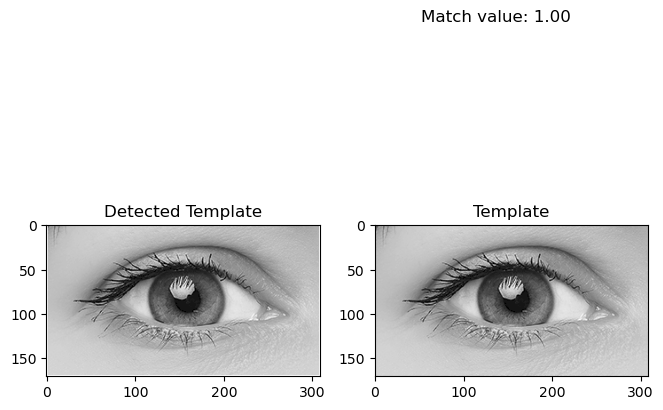

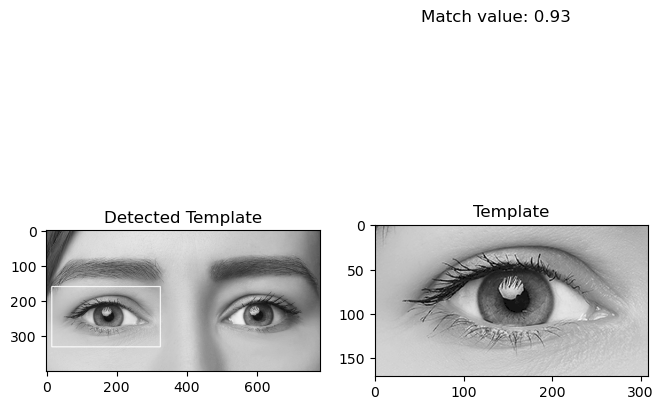

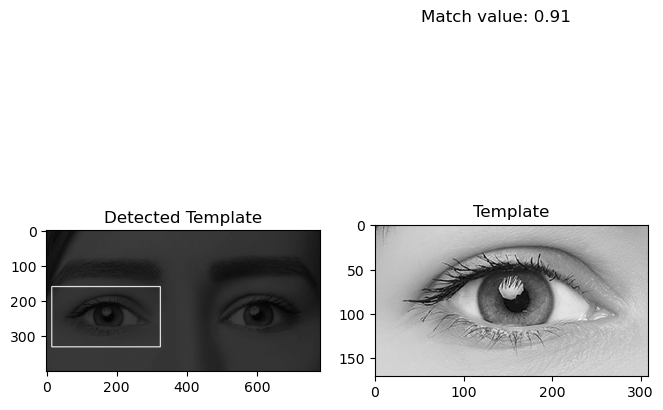

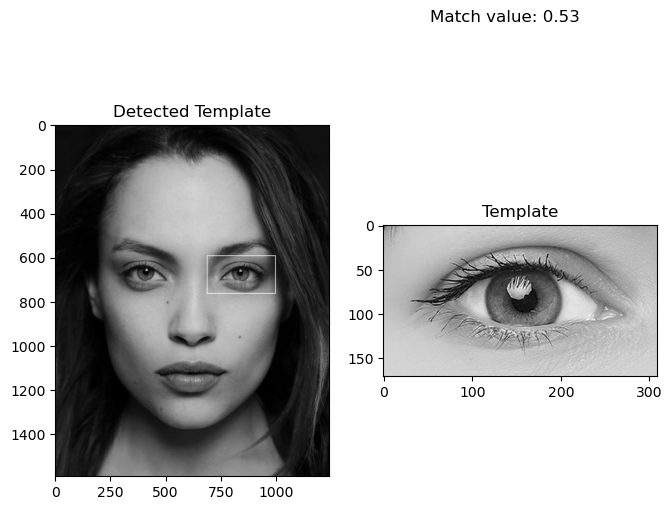

In [8]:

import cv2
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import os


images_path = 'hog/'
template_path = 'hog/eye.png'


def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

def compute_hog(image):
    hog_features, hog_image = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return hog_features, hog_image


def match_template(image, template):

    image = image.astype(np.uint8)
    template = template.astype(np.uint8)
    
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    return max_loc, max_val, result

template = load_image(template_path)
template_hog, template_hog_image = compute_hog(template)


for image_filename in os.listdir(images_path):
    image_path = os.path.join(images_path, image_filename)
    image = load_image(image_path)
    image_hog, image_hog_image = compute_hog(image)

    max_loc, max_val, result = match_template(image_hog_image, template_hog_image)

    h, w = template.shape
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    cv2.rectangle(image, top_left, bottom_right, 255, 2)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Detected Template')
    

    plt.subplot(1, 3, 2)
    plt.imshow(template, cmap='gray')
    plt.title('Template')
    
    plt.suptitle(f'Match value: {max_val:.2f}')
    plt.show()